In [549]:
#1. Data Import + Basic Cleaning + Username/Date Prep

In [550]:
#a one off step, leaving in for reference
!pip install emoji

In [551]:
#step 1 - import the pandas library to work with the csv dataset, numpy for numerical operations, 
#regular expressions for pattern matching, emoji for emoji-related features and Standard Scaler for feature scaling
import pandas as pd
import numpy as np
import re
import emoji
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

#step 2 - load the csv file with tweets
df = pd.read_csv("Tweets.csv")

#step 3 - show the first 5 rows to preview the data
print(df.head())

   id                                               link  \
0   0  https://twitter.com/HackneyPSC/status/17274436...   
1   1  https://twitter.com/cherrysattitude/status/172...   
2   2  https://twitter.com/diamoundgirls2/status/1710...   
3   3  https://twitter.com/mmtchi/status/172764634165...   
4   4  https://twitter.com/NoahIeeNG/status/172744319...   

                                                text              date  likes  \
0  A statement from psychoanalytic activists:  Th...  11/22/2023 21:47      0   
1                        bak bak bak bak doyamadınız  11/22/2023 15:27    443   
2  Check out 🏒 35 + different ERIK KARLSSON cards...    10/7/2023 7:15      0   
3  Il s'en passe des trucs pendant qu'on vous ori...  11/23/2023 11:12    381   
4  AW OKAY.. WELL THATS COOL, IM SURE PAL WILL AP...  11/22/2023 21:45      0   

   comments  
0         0  
1         9  
2         0  
3        44  
4         0  


In [552]:
#step 4 - extract usernames from the tweet link
#the username is always the fourth part after the third "/"
def extract_username(link):
    try:
        return link.split("/")[3] #this gets the username
    except:
        return None #if the link is missing or broken, this returns nothing

df['username'] = df['link'].apply(extract_username)

In [553]:
#step 5 - convert the 'date' column to datetime format needed for timeline features 
df['date'] = pd.to_datetime(df['date'], errors='coerce') #errors='coerce' deals with bad data

#step 6 - drop empty rows
df.dropna(how='all', inplace=True)

In [554]:
#step 7 - print basic info to see how many columns and rows are present
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15498 entries, 0 to 15497
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        15498 non-null  int64         
 1   link      15498 non-null  object        
 2   text      15470 non-null  object        
 3   date      15498 non-null  datetime64[ns]
 4   likes     15498 non-null  int64         
 5   comments  15498 non-null  int64         
 6   username  15498 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 847.7+ KB
None


In [555]:
#2. Feature Extraction

In [556]:
#step 1 - count how many tweets each user posted
tweet_count = df['username'].value_counts().rename_axis('username').reset_index(name='tweet_count')

In [557]:
#step 2 - sort tweets by user and date to calculate the gap between tweets
df_sorted = df.sort_values(by=['username', 'date'])
df_sorted['time_difference'] = df_sorted.groupby('username')['date'].diff().dt.total_seconds()

In [558]:
#step 3 - calculolate average time between tweets for each user in  minutes
average_time_between =  df_sorted.groupby('username')['time_difference'].mean().fillna(0)
average_time_between_minutes = (average_time_between / 60).rename('average_time_between_tweets_minutes')

In [559]:
#step 4 - check how many tweets are written in 50% >= all caps
def is_majority_all_caps(text):
    try:
        words = text. split()
        if not words:
            return False
        return sum(words.isupper() for word in words) / len(words) > 0.5
    except:
        return False

percentage_all_caps = df.groupby('username')['text'].apply(
    lambda tweets: np.mean([is_majority_all_caps(t) for t in tweets])
).rename('percentage_of_tweets_with_all_caps')

In [560]:
#step 5 - count average number of emojis in each tweet
def count_emojis(text):
    if not isinstance(text, str):
        return 0 
    return sum (1 for c in text if c in emoji.EMOJI_DATA)

average_emoji_count = df.groupby('username')['text'].apply(
    lambda tweets: np.mean([count_emojis(t) for t in tweets])
).rename('average_emoji_count_per_tweet')

In [561]:
#step 6 - track emotionally intense language using a lexicon
emotional_words = set()
target_emotions = {'anger', 'fear', 'disgust', 'sadness', 'negative'} #this focuses on words that fall under these categories

with open("NRC-Emotion-Lexicon-Wordlevel-v0.92.txt", "r", encoding="utf-8") as file:
    for line in file:
        parts = line.strip().split("\t")
        if len(parts) ==3:
            word, emotion, assoc = parts
            if assoc =='1' and emotion in target_emotions:
                emotional_words.add(word)

def count_emotional_words(text):
    if not isinstance(text, str):
        return 0
    words = re.findall(r'\b\w+\b', text.lower())
    return sum(word in emotional_words for word in words)

average_emotion_words = df.groupby('username')['text'].apply(
    lambda tweets: np.mean([count_emotional_words(t) for t in tweets])
).rename('average_emotionally_charged_words_per_tweet')

In [562]:
#step 7 - calculate tweet length average per user
average_tweet_length = df.groupby('username')['text'].apply(
    lambda tweets: np.mean([len(str(t)) for t in tweets])
).rename('average_tweet_length')

In [563]:
#step 8 - count average number of hashtags per tweet 
def count_hashtags(text):
    return len(re.findall(r'#\w+', str(text)))

average_hashtags = df.groupby('username')['text'].apply(
    lambda tweets: np.mean([count_hashtags(t) for t in tweets])
).rename('average_hashtag_frequency_per_tweet')

In [564]:
#step 9 - set tweet count index to match others
tweet_count = tweet_count.set_index('username')

In [565]:
#step 10 - combine all features coded until now into one dataset
feature_matrix = pd.concat([
    tweet_count,
    average_time_between_minutes,
    percentage_all_caps,
    average_emoji_count,
    average_emotion_words,
    average_tweet_length,
    average_hashtags
], axis=1)

In [566]:
#step 10a - adding tweet length cap as this distorted the plot with outliers being too far from the centroid
feature_matrix['average_tweet_length'] = feature_matrix['average_tweet_length'].clip(upper=1000)

In [567]:
#step 11 - chech the final result
print(feature_matrix.head())

                 tweet_count  average_time_between_tweets_minutes  \
username                                                            
Novytique                 84                            45.156627   
salusalemchalom           48                             5.851064   
Kuwait_KW01               38                           102.054054   
diamoundgirls2            37                            27.305556   
AvivaKlompas              31                           958.433333   

                 percentage_of_tweets_with_all_caps  \
username                                              
Novytique                                       0.0   
salusalemchalom                                 0.0   
Kuwait_KW01                                     0.0   
diamoundgirls2                                  0.0   
AvivaKlompas                                    0.0   

                 average_emoji_count_per_tweet  \
username                                         
Novytique                     

In [568]:
#3. Feature Scaling

In [569]:
#step 1 - use StandardScaler to normalise all values so they are similar in range
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_matrix)

In [570]:
#step 2 - convert back to dataframe so we can still see column names
scaled_df = pd.DataFrame(scaled_features, columns=feature_matrix.columns, index=feature_matrix.index)

In [571]:
#step 3 - check the final scaled values
print(scaled_df.head())

                 tweet_count  average_time_between_tweets_minutes  \
username                                                            
Novytique          46.443893                            -0.038475   
salusalemchalom    26.189500                            -0.040856   
Kuwait_KW01        20.563280                            -0.035029   
diamoundgirls2     20.000658                            -0.039557   
AvivaKlompas       16.624925                             0.016839   

                 percentage_of_tweets_with_all_caps  \
username                                              
Novytique                                       0.0   
salusalemchalom                                 0.0   
Kuwait_KW01                                     0.0   
diamoundgirls2                                  0.0   
AvivaKlompas                                    0.0   

                 average_emoji_count_per_tweet  \
username                                         
Novytique                     

In [572]:
#4. DBSCAN 

In [573]:
#step 1 - apply DBSCAN clustering to the scaled features
dbscan = DBSCAN(eps=1.2, min_samples=5)
dbscan_labels = dbscan.fit_predict(scaled_df)

In [574]:
#step 2 - assign DBSCAN labels back to the dataframe
feature_matrix['dbscan_cluster'] = dbscan_labels
df = df.merge(feature_matrix['dbscan_cluster'], left_on='username', right_index=True, how='left')

In [575]:
#step 3 - check how many clusters and outliers are found
print("DBSCAN labels count:")
print(feature_matrix['dbscan_cluster'].value_counts())

DBSCAN labels count:
dbscan_cluster
 1    10519
-1      151
 2        6
 0        5
Name: count, dtype: int64


In [576]:
#step 4 - outlier (-1) preview
outliers = feature_matrix[feature_matrix['dbscan_cluster'] == -1]
print(outliers.sort_values(by='tweet_count', ascending=False).head(10))

                 tweet_count  average_time_between_tweets_minutes  \
username                                                            
Novytique                 84                            45.156627   
salusalemchalom           48                             5.851064   
Kuwait_KW01               38                           102.054054   
diamoundgirls2            37                            27.305556   
AvivaKlompas              31                           958.433333   
jacksonhinklle            29                          2059.000000   
EviesSantiago             26                          1155.280000   
everydropoftear           24                            15.260870   
MaxChar13                 23                            11.727273   
EPLPeter                  20                             1.263158   

                 percentage_of_tweets_with_all_caps  \
username                                              
Novytique                                       0.0   
salusa

In [577]:
#step 5 - week column to track tweets per week
df['week'] = df['date'].dt.to_period('W').astype(str)

In [578]:
#step 6 - assign dbscan cluster labels to users in the feature matrix
feature_matrix['dbscan_cluster'] = dbscan.labels_

In [579]:
#step 7 - merge this back into the main dataframe by username
df = df.drop(columns=['dbscan_cluster'], errors='ignore')
df = df.merge(feature_matrix[['dbscan_cluster']], left_on='username', right_index=True, how='left')

In [580]:
#step 8 - group by username and week to calculate weekly feature changes
dbscan_weekly = df.groupby(['username', 'week']).agg(
    weekly_tweet_count=('text', 'count'),
    average_tweet_length=('text', lambda t: np.mean([len(str(x)) for x in t])),
    total_emojis=('text', lambda t: sum(count_emojis(x) for x in t)),
    total_emotional_words=('text', lambda t: sum(count_emotional_words(x) for x in t)),
    average_time_between_tweets_minutesh=('date', lambda d: d.sort_values().diff().dt.total_seconds().mean() / 60 if len(d) > 1 else 0),
    dbscan_cluster=('dbscan_cluster', 'first')
).reset_index()

In [581]:
#step 9 - preview the weekly tracking
print(dbscan_weekly.head())

      username                   week  weekly_tweet_count  \
0    001Flight  2023-12-11/2023-12-17                   1   
1    0130Coach  2023-12-11/2023-12-17                   1   
2       01IOTA  2023-12-11/2023-12-17                   1   
3  021Scenario  2023-12-11/2023-12-17                   1   
4        06Kiu  2023-11-20/2023-11-26                   1   

   average_tweet_length  total_emojis  total_emotional_words  \
0                  63.0             0                      1   
1                 453.0             0                      8   
2                 280.0             0                      2   
3                  40.0             0                      0   
4                  73.0             0                      0   

   average_time_between_tweets_minutesh  dbscan_cluster  
0                                   0.0               1  
1                                   0.0               1  
2                                   0.0               1  
3               

In [582]:
#step 10 - choose a user to analyse
selected_user = "Kuwait_KW01" #this user has the highest tweets posted

In [583]:
#step 11 - filter weekly metrics just for this user
user_weekly = dbscan_weekly[dbscan_weekly['username'] == selected_user].sort_values('week')

In [584]:
#step 12 - features to plot
features_to_plot = [
    'weekly_tweet_count',
    'total_emojis',
    'total_emotional_words',
    'average_tweet_length'
]

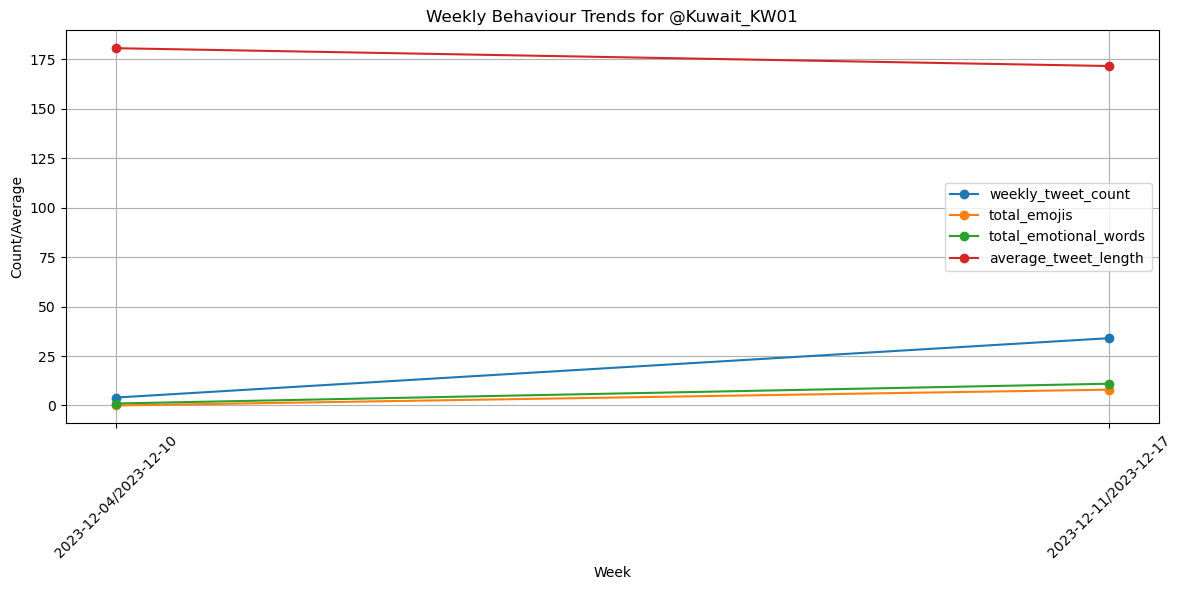

In [585]:
#step 13 - create a line plot to show behavioural changes over weeks
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for feature in features_to_plot:
    plt.plot(user_weekly['week'], user_weekly[feature], marker='o', label=feature)

plt.title(f"Weekly Behaviour Trends for @Kuwait_KW01")
plt.xlabel("Week")
plt.ylabel("Count/Average")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

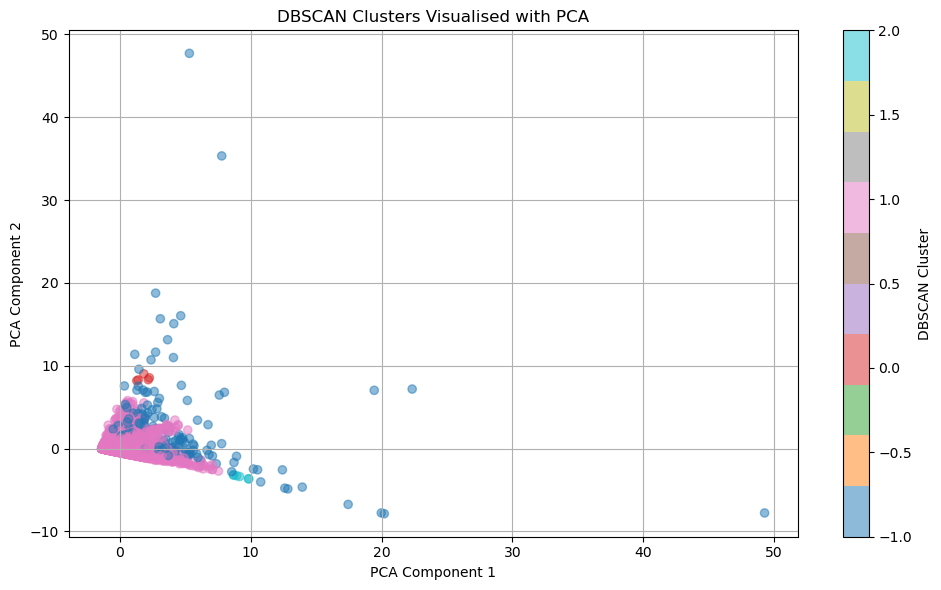

In [586]:
# step 13 again - PCA 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_df)

#create a dataframe for plotting
pca_df = pd.DataFrame(data=pca_components, columns=['PCA1', 'PCA2'])
pca_df['cluster'] = feature_matrix['dbscan_cluster'].values

plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_df['PCA1'], pca_df['PCA2'], c=pca_df['cluster'], cmap='tab10', alpha=0.5)
plt.title('DBSCAN Clusters Visualised with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='DBSCAN Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()